# Latitudinal section through bottomw water outcropping of temperature, salinity and $\sigma_2$

In [1]:
from dask_gateway import GatewayCluster

cluster = GatewayCluster()
cluster.scale(30)
#cluster.adapt(minimum=2, maximum=25)  # or cluster.scale(n) to a fixed size.
client = cluster.get_client()

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask_gateway/client.py:21: FutureWarning: format_bytes is deprecated and will be removed in a future release. Please use dask.utils.format_bytes instead.
  from distributed.utils import LoopRunner, format_bytes


In [2]:
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.7714210a184a4a94aa609e173c2f1890/status,


In [17]:
client.close()
cluster.close()

In [3]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import fsspec
import json
from xmitgcm.llcreader.llcmodel import faces_dataset_to_latlon
import gsw
from fastjmd95 import jmd95numba

In [4]:
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

In [5]:
ds_slt = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/ECCO/datasets/ds_slt_wg_new.zarr'), consolidated=False)
ds_tmp = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/ECCO/datasets/ds_tmp_wg.zarr'), consolidated=False)

In [6]:
ds_orig = xr.open_zarr(gcsfs.GCSFileSystem(requester_pays=True).get_mapper('pangeo-ecco-eccov4r3/eccov4r3'), consolidated=True)
ds_ll = faces_dataset_to_latlon(ds_orig)
ds_ll_drop = ds_ll.drop(['i', 'j', 'i_g', 'j_g']) #, 'k', 'k_u', 'k_l', 'k_p1'])
coords = ds_ll_drop.coords.to_dataset().reset_coords().roll(i=50, i_g=50)#(i=100, i_g=100)
ds = ds_ll_drop.reset_coords(drop=True).roll(i=50, i_g=50)#(i=100, i_g=100)

#WG boundaries (65˚W, 30˚E; 80˚S, 62˚S)
left_lon = 23 #~-64.5˚ #used to be 20
right_lon = 118 #30.5˚ #used to be 115
lower_lat = 30 #~-80˚ #used to be 38
upper_lat = 80 #-61.755745˚ instead of #79:-62.216576˚ to fill upper projection plot row
j_g_upper = 81
i_g_right = 119
i_g_left = 22

#set the boundaries
lat_range = dict(j=slice(lower_lat, upper_lat), j_g=slice(lower_lat, j_g_upper))
lon_range = dict(i=slice(left_lon, right_lon), i_g=slice(left_lon, i_g_right))
lat_range_noface = dict(j=slice(lower_lat, upper_lat))
lon_range_noface = dict(i=slice(left_lon, right_lon))

ds_wg = ds.isel(**lat_range, **lon_range)
coords_wg = coords.isel(**lat_range, **lon_range)

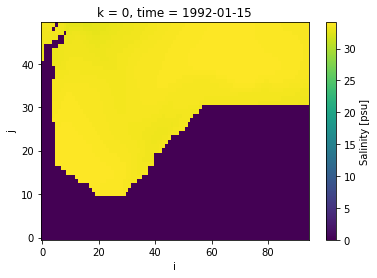

In [19]:
ds_wg.SALT[0,0].plot()

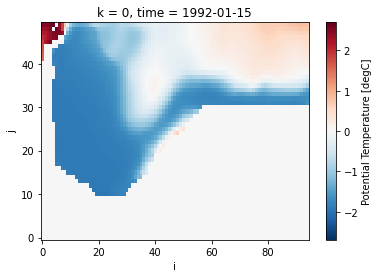

In [21]:
ds_wg.THETA[0,0].plot()

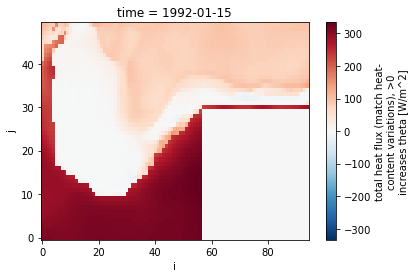

In [25]:
ds_wg.TFLUX[0].plot()

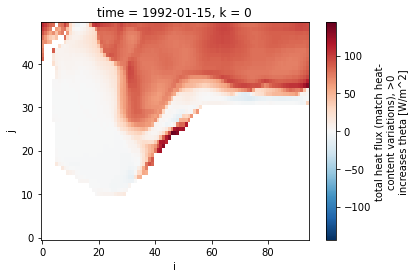

In [28]:
ds_wg.TFLUX[0].where(mask[0]).plot()

In [7]:
sigma2 = xr.apply_ufunc(jmd95numba.rho, ds_wg.SALT.chunk({'time':1, 'k':-1, 'j':-1, 'i':-1}), 
                        ds_wg.THETA.chunk({'time':1, 'k':-1, 'j':-1, 'i':-1}), 2000,
                            output_dtypes=[ds_wg.SALT.chunk({'time':1, 'k':-1, 'j':-1, 'i':-1}).astype('f8').dtype],
                            dask='parallelized').reset_coords(drop=True)

In [8]:
sigma2

,Array,Chunk
Bytes,521.85 MiB,1.81 MiB
Shape,"(288, 50, 50, 95)","(1, 50, 50, 95)"
Count,72291 Tasks,288 Chunks
Type,float64,numpy.ndarray


In [9]:
mask = coords_wg.hFacC > 0

In [10]:
mask

<xarray.DataArray 'hFacC' (k: 50, j: 50, i: 95)>
dask.array<gt, shape=(50, 50, 95), dtype=bool, chunksize=(50, 50, 67), chunktype=numpy.ndarray>
Coordinates:
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
Dimensions without coordinates: j, i

In [11]:
sigma2_m = sigma2.where(mask)

In [12]:
sigma2_m

,Array,Chunk
Bytes,521.85 MiB,1.28 MiB
Shape,"(288, 50, 50, 95)","(1, 50, 50, 67)"
Count,74145 Tasks,576 Chunks
Type,float64,numpy.ndarray


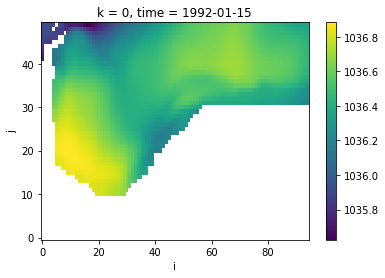

In [13]:
sigma2_m[0,0].plot()

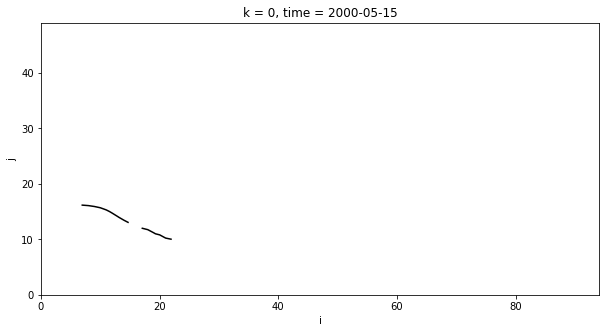

In [33]:
fig, ax = plt.subplots(figsize=(10,5))
sigma2_m.isel(k=0, time=100).plot.contour(colors='k', levels=[1037.125], linewidth=8, label='', ax=ax)
C.collections[0].set_linewidth(3)

In [73]:
client.restart()

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.7714210a184a4a94aa609e173c2f1890/status,


/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/plot/plot.py:1415: UserWarning: The following kwargs were not used by contour: 'linewidth', 'label'
  primitive = ax.contour(x, y, z, **kwargs)
/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/plot/plot.py:1415: UserWarning: The following kwargs were not used by contour: 'linewidth', 'label'
  primitive = ax.contour(x, y, z, **kwargs)


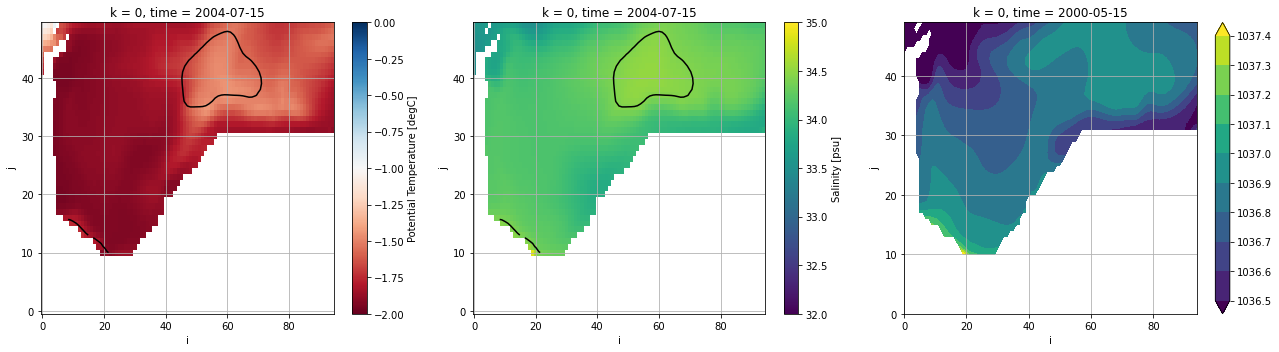

In [58]:
tt = '2004-07-15'
fig, (ax0,ax1,ax2) = plt.subplots(1, 3, figsize=(18,5))

sigma2_m.sel(k=0, time=tt).plot.contour(colors='k', levels=[1037.125], linewidth=8, label='', ax=ax0)
ds_wg.THETA.where(mask).sel(k=0, time=tt).plot(cmap='RdBu', vmin=-2, vmax=0, ax=ax0)
ax0.grid()

sigma2_m.sel(k=0, time=tt).plot.contour(colors='k', levels=[1037.125], linewidth=8, label='', ax=ax1)
ds_wg.SALT.where(mask).sel(k=0, time=tt).plot(vmin=32, vmax=35, ax=ax1)
ax1.grid()

sigma2_m[100, 0].plot.contourf(levels=np.arange(1036.5, 1037.5, 0.1), ax=ax2)
ax2.grid()

plt.tight_layout();

In [65]:
sigma40 = sigma2_m.isel(j=40)
temp40 = ds_wg.THETA.isel(j=40)
salt40 = ds_wg.SALT.isel(j=40)
mask40 = mask.isel(j=40)

In [62]:
sigma40

<xarray.DataArray (time: 288, k: 50, i: 95)>
dask.array<getitem, shape=(288, 50, 95), dtype=float64, chunksize=(1, 50, 67), chunktype=numpy.ndarray>
Coordinates:
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
Dimensions without coordinates: i

/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/plot/plot.py:1415: UserWarning: The following kwargs were not used by contour: 'linewidth', 'label'
  primitive = ax.contour(x, y, z, **kwargs)


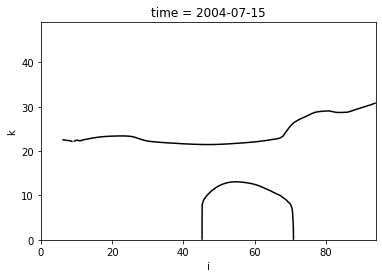

In [77]:
sigma40.sel(time=tt).plot.contour(colors='k', levels=[1037.125], linewidth=8, label='')

/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/plot/plot.py:1415: UserWarning: The following kwargs were not used by contour: 'linewidth', 'label'
  primitive = ax.contour(x, y, z, **kwargs)
/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/plot/plot.py:1415: UserWarning: The following kwargs were not used by contour: 'linewidth', 'label'
  primitive = ax.contour(x, y, z, **kwargs)


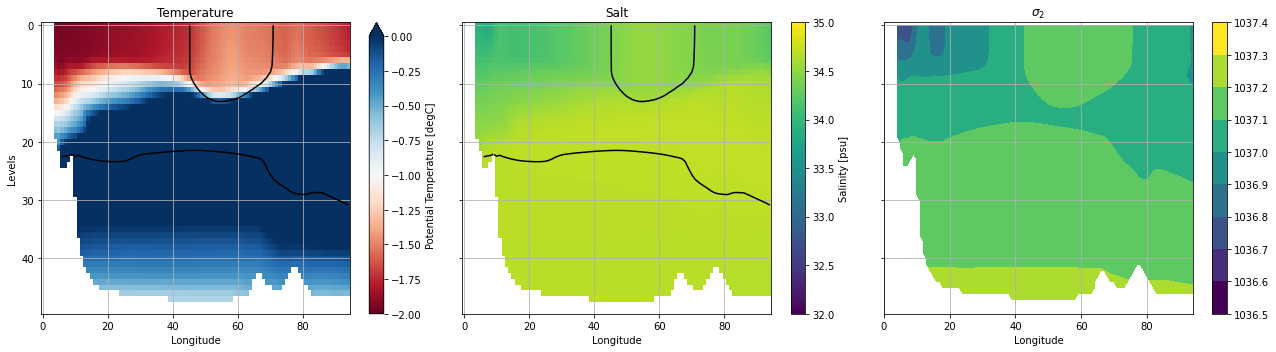

In [81]:
tt = '2004-07-15'
fig, (ax0,ax1,ax2) = plt.subplots(1, 3, figsize=(18,5), sharey=True)

sigma40.sel(time=tt).plot.contour(colors='k', levels=[1037.125], linewidth=8, label='', ax=ax0, yincrease=False)
temp40.where(mask40).sel(time=tt).plot(cmap='RdBu', vmin=-2, vmax=0, ax=ax0, yincrease=False)
ax0.set_title('Temperature')
ax0.set_ylabel('Levels')
ax0.set_xlabel('Longitude')
ax0.grid()

sigma40.sel(time=tt).plot.contour(colors='k', levels=[1037.125], linewidth=8, label='', ax=ax1, yincrease=False)
salt40.where(mask40).sel(time=tt).plot(vmin=32, vmax=35, ax=ax1, yincrease=False)
ax1.set_title('Salt')
ax1.set_ylabel('')
ax1.set_xlabel('Longitude')
ax1.grid()

sigma40.sel(time=tt).plot.contourf(levels=np.arange(1036.5, 1037.5, 0.1), ax=ax2, yincrease=False)
ax2.set_title(r'$\sigma_2$')
ax2.set_ylabel('')
ax2.set_xlabel('Longitude')
ax2.grid()

plt.tight_layout();